# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

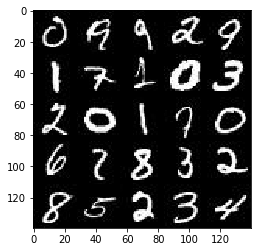

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

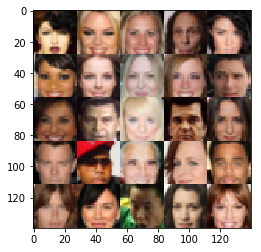

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='real_input')
    inputs_z = tf.placeholder(tf.float32,(None,z_dim),name='z_input')
    learn_rate = tf.placeholder(tf.float16,name='learning_rate')
    return (inputs_real,inputs_z,learn_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator',reuse=reuse):
        #input layer 28x28x3
        x1 = tf.layers.conv2d(images,64,5,strides=2,padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    reuse = True
    if is_train:
        reuse = False
            
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 7*7*256)

        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        ##7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        ##14x14x128
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        ##28x28x3
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, learn_rate = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    d_loss,g_loss = model_loss(input_real,input_z,data_shape[3])
    d_train_opt,g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    steps = 0
    print_loss = 20
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images *2 
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate : learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate : learning_rate})
                
                if (steps)%25 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Steps {}/{}...".format(steps, 100),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps%100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    steps = 0


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Steps 25/100... Discriminator Loss: 0.5124... Generator Loss: 1.7222
Steps 50/100... Discriminator Loss: 0.6480... Generator Loss: 2.4377
Steps 75/100... Discriminator Loss: 0.7416... Generator Loss: 1.1102
Steps 100/100... Discriminator Loss: 0.7228... Generator Loss: 2.0613


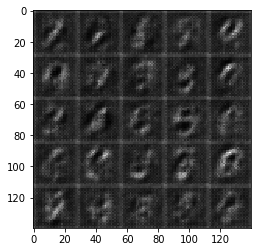

Steps 25/100... Discriminator Loss: 0.8078... Generator Loss: 1.0215
Steps 50/100... Discriminator Loss: 1.2123... Generator Loss: 0.4654
Steps 75/100... Discriminator Loss: 1.0155... Generator Loss: 0.5345
Steps 100/100... Discriminator Loss: 0.6643... Generator Loss: 2.7708


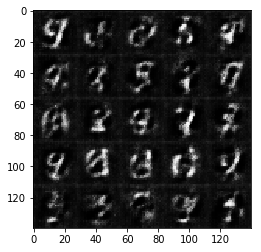

Steps 25/100... Discriminator Loss: 1.0805... Generator Loss: 0.5198
Steps 50/100... Discriminator Loss: 1.0600... Generator Loss: 3.3328
Steps 75/100... Discriminator Loss: 0.4366... Generator Loss: 1.9756
Steps 100/100... Discriminator Loss: 0.5263... Generator Loss: 1.6685


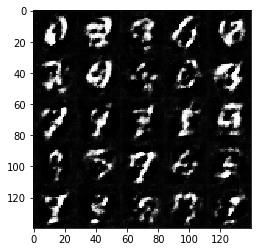

Steps 25/100... Discriminator Loss: 0.9173... Generator Loss: 0.6704
Steps 50/100... Discriminator Loss: 0.4849... Generator Loss: 1.4337
Steps 75/100... Discriminator Loss: 0.3766... Generator Loss: 1.5566
Steps 100/100... Discriminator Loss: 0.3373... Generator Loss: 2.2351


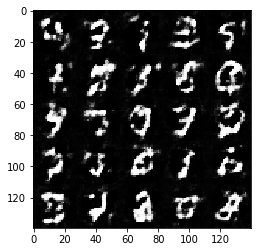

Steps 25/100... Discriminator Loss: 0.4451... Generator Loss: 1.6456
Steps 50/100... Discriminator Loss: 0.3861... Generator Loss: 1.5682
Steps 75/100... Discriminator Loss: 0.2779... Generator Loss: 2.0491
Steps 100/100... Discriminator Loss: 0.3993... Generator Loss: 2.4744


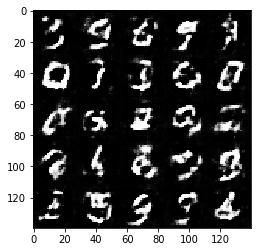

Steps 25/100... Discriminator Loss: 0.6614... Generator Loss: 0.9742
Steps 50/100... Discriminator Loss: 0.3027... Generator Loss: 3.0398
Steps 75/100... Discriminator Loss: 0.3750... Generator Loss: 1.8467
Steps 100/100... Discriminator Loss: 0.5865... Generator Loss: 1.1149


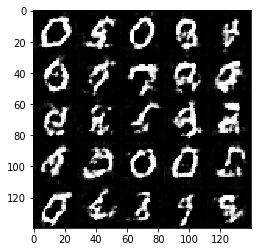

Steps 25/100... Discriminator Loss: 0.7478... Generator Loss: 3.0714
Steps 50/100... Discriminator Loss: 0.4953... Generator Loss: 1.9868
Steps 75/100... Discriminator Loss: 0.6626... Generator Loss: 0.9477
Steps 100/100... Discriminator Loss: 0.3821... Generator Loss: 1.6185


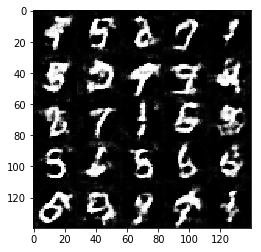

Steps 25/100... Discriminator Loss: 0.7860... Generator Loss: 1.4519
Steps 50/100... Discriminator Loss: 0.4439... Generator Loss: 1.7349
Steps 75/100... Discriminator Loss: 0.5869... Generator Loss: 1.2923
Steps 100/100... Discriminator Loss: 0.3877... Generator Loss: 1.6265


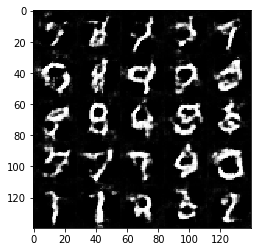

Steps 25/100... Discriminator Loss: 0.5104... Generator Loss: 2.0218
Steps 50/100... Discriminator Loss: 0.5009... Generator Loss: 1.3113
Steps 75/100... Discriminator Loss: 0.9858... Generator Loss: 0.5726
Steps 100/100... Discriminator Loss: 0.3845... Generator Loss: 2.0347


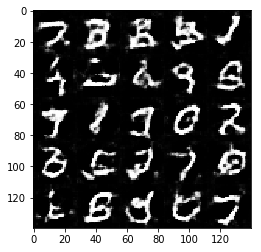

Steps 25/100... Discriminator Loss: 0.5599... Generator Loss: 1.4627
Steps 50/100... Discriminator Loss: 0.3880... Generator Loss: 2.0368
Steps 75/100... Discriminator Loss: 0.6109... Generator Loss: 1.1605
Steps 100/100... Discriminator Loss: 0.7510... Generator Loss: 0.8814


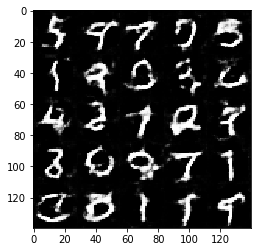

Steps 25/100... Discriminator Loss: 0.6003... Generator Loss: 1.1996
Steps 50/100... Discriminator Loss: 0.5629... Generator Loss: 1.2769
Steps 75/100... Discriminator Loss: 0.9517... Generator Loss: 0.6704
Steps 100/100... Discriminator Loss: 0.6557... Generator Loss: 3.1256


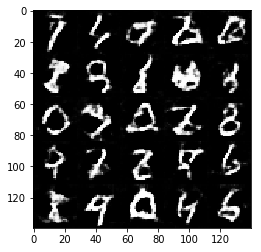

Steps 25/100... Discriminator Loss: 1.1811... Generator Loss: 0.4850
Steps 50/100... Discriminator Loss: 1.4537... Generator Loss: 0.3487
Steps 75/100... Discriminator Loss: 0.4926... Generator Loss: 2.2546
Steps 100/100... Discriminator Loss: 0.6739... Generator Loss: 2.4840


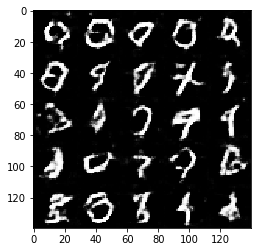

Steps 25/100... Discriminator Loss: 0.6801... Generator Loss: 0.9028
Steps 50/100... Discriminator Loss: 0.7000... Generator Loss: 0.9249
Steps 75/100... Discriminator Loss: 0.7320... Generator Loss: 0.8689
Steps 100/100... Discriminator Loss: 0.4801... Generator Loss: 1.5619


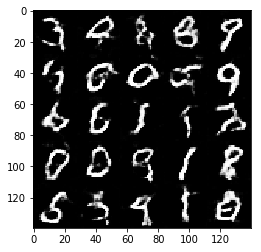

Steps 25/100... Discriminator Loss: 1.1377... Generator Loss: 0.4838
Steps 50/100... Discriminator Loss: 0.5759... Generator Loss: 2.3951
Steps 75/100... Discriminator Loss: 0.7682... Generator Loss: 0.8631
Steps 100/100... Discriminator Loss: 0.5253... Generator Loss: 1.2087


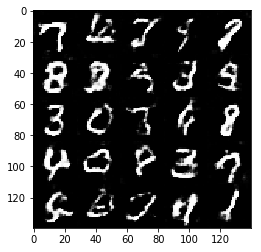

Steps 25/100... Discriminator Loss: 0.6946... Generator Loss: 0.9427
Steps 50/100... Discriminator Loss: 0.5979... Generator Loss: 0.9778
Steps 75/100... Discriminator Loss: 0.7152... Generator Loss: 0.9839
Steps 100/100... Discriminator Loss: 0.5697... Generator Loss: 1.1312


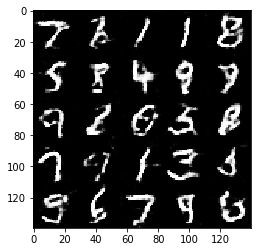

Steps 25/100... Discriminator Loss: 0.4871... Generator Loss: 1.1280
Steps 50/100... Discriminator Loss: 4.1072... Generator Loss: 7.6972
Steps 75/100... Discriminator Loss: 0.7212... Generator Loss: 1.9158
Steps 100/100... Discriminator Loss: 0.5664... Generator Loss: 1.4662


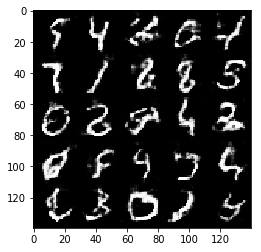

Steps 25/100... Discriminator Loss: 0.4655... Generator Loss: 1.3168
Steps 50/100... Discriminator Loss: 0.3831... Generator Loss: 1.5422
Steps 75/100... Discriminator Loss: 0.3774... Generator Loss: 1.5863
Steps 100/100... Discriminator Loss: 0.8926... Generator Loss: 0.7166


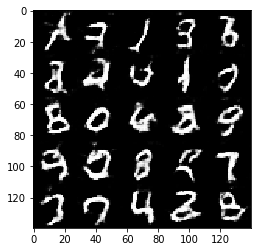

Steps 25/100... Discriminator Loss: 0.4465... Generator Loss: 1.3997
Steps 50/100... Discriminator Loss: 0.4377... Generator Loss: 1.6208
Steps 75/100... Discriminator Loss: 0.5521... Generator Loss: 1.2434
Steps 100/100... Discriminator Loss: 1.7385... Generator Loss: 0.2584


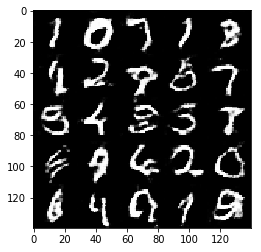

Steps 25/100... Discriminator Loss: 1.7982... Generator Loss: 0.2766
Steps 50/100... Discriminator Loss: 0.4054... Generator Loss: 1.8521
Steps 75/100... Discriminator Loss: 0.3810... Generator Loss: 1.4079
Steps 100/100... Discriminator Loss: 0.8715... Generator Loss: 0.7519


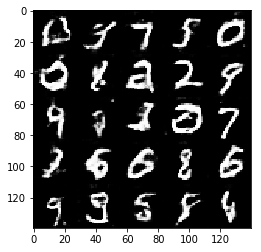

Steps 25/100... Discriminator Loss: 0.5049... Generator Loss: 1.2569
Steps 50/100... Discriminator Loss: 0.2326... Generator Loss: 1.8679
Steps 75/100... Discriminator Loss: 1.3727... Generator Loss: 0.4194
Steps 100/100... Discriminator Loss: 0.8578... Generator Loss: 0.7227


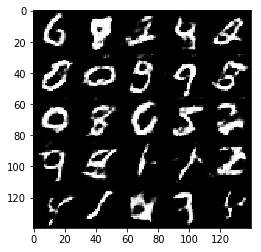

Steps 25/100... Discriminator Loss: 0.6470... Generator Loss: 1.0972
Steps 50/100... Discriminator Loss: 0.4781... Generator Loss: 1.3409
Steps 75/100... Discriminator Loss: 0.2888... Generator Loss: 1.7679
Steps 100/100... Discriminator Loss: 0.4864... Generator Loss: 1.2752


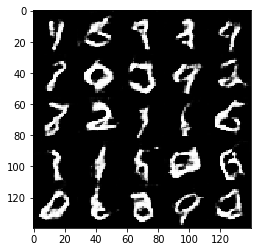

Steps 25/100... Discriminator Loss: 0.4050... Generator Loss: 2.7566
Steps 50/100... Discriminator Loss: 0.5591... Generator Loss: 1.2336
Steps 75/100... Discriminator Loss: 0.7657... Generator Loss: 0.8573
Steps 100/100... Discriminator Loss: 0.5890... Generator Loss: 1.0476


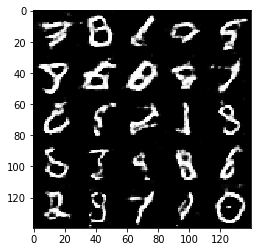

Steps 25/100... Discriminator Loss: 0.2791... Generator Loss: 1.9709
Steps 50/100... Discriminator Loss: 0.5172... Generator Loss: 1.3476
Steps 75/100... Discriminator Loss: 0.2737... Generator Loss: 1.8061
Steps 100/100... Discriminator Loss: 0.4660... Generator Loss: 1.3512


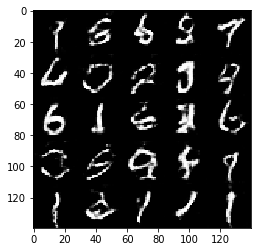

Steps 25/100... Discriminator Loss: 0.9669... Generator Loss: 0.6783
Steps 50/100... Discriminator Loss: 0.5153... Generator Loss: 1.6987
Steps 75/100... Discriminator Loss: 0.3549... Generator Loss: 1.6326
Steps 100/100... Discriminator Loss: 0.4936... Generator Loss: 1.2700


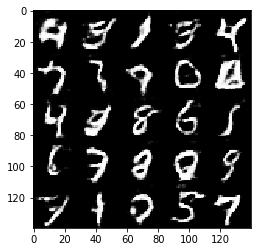

Steps 25/100... Discriminator Loss: 0.2504... Generator Loss: 1.8706
Steps 50/100... Discriminator Loss: 0.8204... Generator Loss: 0.7400
Steps 75/100... Discriminator Loss: 0.8149... Generator Loss: 0.8092
Steps 100/100... Discriminator Loss: 1.0103... Generator Loss: 3.5743


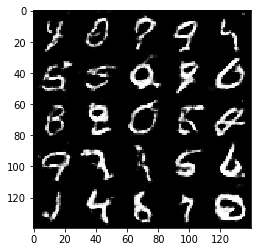

Steps 25/100... Discriminator Loss: 0.3539... Generator Loss: 1.4601
Steps 50/100... Discriminator Loss: 0.5546... Generator Loss: 1.2794
Steps 75/100... Discriminator Loss: 0.5830... Generator Loss: 1.1096
Steps 100/100... Discriminator Loss: 0.7724... Generator Loss: 1.0490


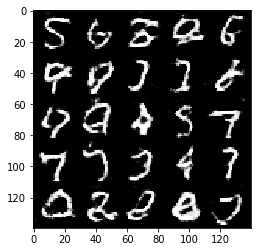

Steps 25/100... Discriminator Loss: 0.7662... Generator Loss: 2.7391
Steps 50/100... Discriminator Loss: 0.4186... Generator Loss: 2.0340
Steps 75/100... Discriminator Loss: 0.5325... Generator Loss: 1.2045
Steps 100/100... Discriminator Loss: 0.5683... Generator Loss: 1.2714


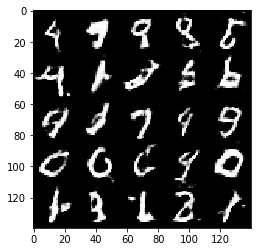

Steps 25/100... Discriminator Loss: 0.5031... Generator Loss: 1.2555
Steps 50/100... Discriminator Loss: 0.2899... Generator Loss: 1.7805
Steps 75/100... Discriminator Loss: 0.4027... Generator Loss: 1.6716
Steps 100/100... Discriminator Loss: 0.4148... Generator Loss: 1.6786


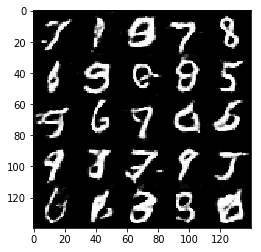

Steps 25/100... Discriminator Loss: 0.5046... Generator Loss: 1.5447
Steps 50/100... Discriminator Loss: 0.9687... Generator Loss: 0.7721
Steps 75/100... Discriminator Loss: 0.3252... Generator Loss: 1.8502
Steps 100/100... Discriminator Loss: 0.9085... Generator Loss: 0.7254


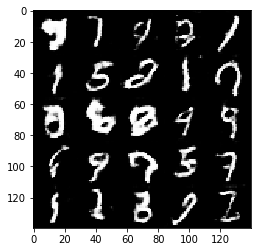

Steps 25/100... Discriminator Loss: 0.3498... Generator Loss: 1.6522
Steps 50/100... Discriminator Loss: 0.3363... Generator Loss: 1.7435
Steps 75/100... Discriminator Loss: 0.5858... Generator Loss: 1.1095
Steps 100/100... Discriminator Loss: 0.5863... Generator Loss: 1.0882


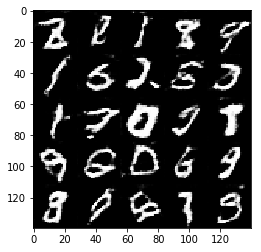

Steps 25/100... Discriminator Loss: 0.6235... Generator Loss: 1.3502
Steps 50/100... Discriminator Loss: 0.7076... Generator Loss: 0.8454
Steps 75/100... Discriminator Loss: 0.2963... Generator Loss: 1.9085
Steps 100/100... Discriminator Loss: 1.2032... Generator Loss: 0.6940


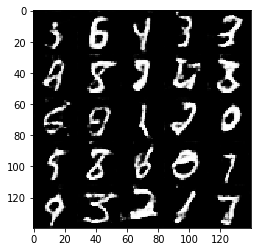

Steps 25/100... Discriminator Loss: 1.0298... Generator Loss: 0.6096
Steps 50/100... Discriminator Loss: 0.4596... Generator Loss: 1.3695
Steps 75/100... Discriminator Loss: 0.2633... Generator Loss: 3.8975
Steps 100/100... Discriminator Loss: 0.4656... Generator Loss: 1.2608


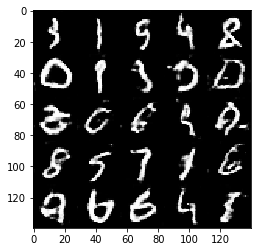

Steps 25/100... Discriminator Loss: 1.9446... Generator Loss: 0.2511
Steps 50/100... Discriminator Loss: 0.7058... Generator Loss: 0.9973
Steps 75/100... Discriminator Loss: 0.3632... Generator Loss: 1.8155
Steps 100/100... Discriminator Loss: 0.8394... Generator Loss: 0.9248


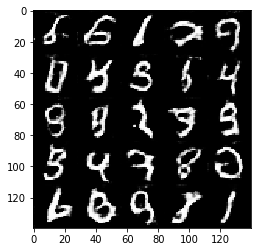

Steps 25/100... Discriminator Loss: 0.3310... Generator Loss: 1.8375
Steps 50/100... Discriminator Loss: 0.7731... Generator Loss: 0.8287
Steps 75/100... Discriminator Loss: 0.2958... Generator Loss: 1.7564
Steps 100/100... Discriminator Loss: 0.5551... Generator Loss: 1.1727


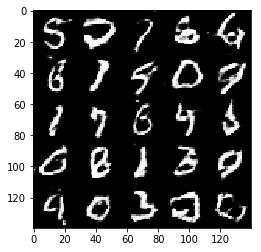

Steps 25/100... Discriminator Loss: 0.7651... Generator Loss: 0.8404
Steps 50/100... Discriminator Loss: 0.3910... Generator Loss: 1.7072
Steps 75/100... Discriminator Loss: 2.3476... Generator Loss: 0.2187
Steps 100/100... Discriminator Loss: 0.4580... Generator Loss: 1.3137


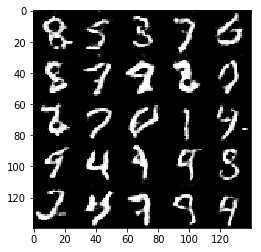

Steps 25/100... Discriminator Loss: 0.3482... Generator Loss: 1.6398
Steps 50/100... Discriminator Loss: 0.3806... Generator Loss: 1.6415
Steps 75/100... Discriminator Loss: 1.1642... Generator Loss: 0.5036
Steps 100/100... Discriminator Loss: 0.3472... Generator Loss: 1.6277


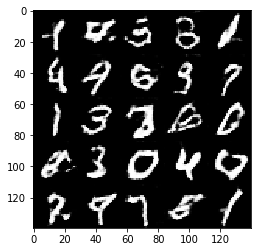

Steps 25/100... Discriminator Loss: 0.2905... Generator Loss: 3.3830
Steps 50/100... Discriminator Loss: 0.4895... Generator Loss: 1.3146
Steps 75/100... Discriminator Loss: 3.4906... Generator Loss: 7.1017
Steps 100/100... Discriminator Loss: 0.6970... Generator Loss: 1.0425


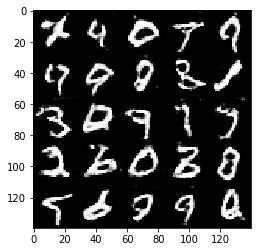

Steps 25/100... Discriminator Loss: 0.2652... Generator Loss: 1.9674
Steps 50/100... Discriminator Loss: 0.3876... Generator Loss: 1.5923


In [20]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Steps 25/100... Discriminator Loss: 0.3133... Generator Loss: 1.6626
Steps 50/100... Discriminator Loss: 0.3400... Generator Loss: 1.8932
Steps 75/100... Discriminator Loss: 1.4829... Generator Loss: 0.3454
Steps 100/100... Discriminator Loss: 0.3959... Generator Loss: 1.7405


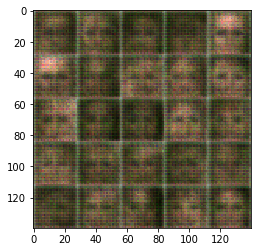

Steps 25/100... Discriminator Loss: 0.7575... Generator Loss: 1.1466
Steps 50/100... Discriminator Loss: 0.6668... Generator Loss: 1.5657
Steps 75/100... Discriminator Loss: 1.0244... Generator Loss: 0.7287
Steps 100/100... Discriminator Loss: 0.8339... Generator Loss: 1.4396


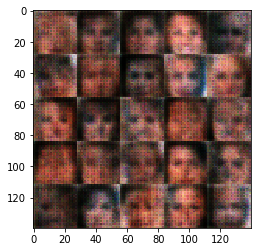

Steps 25/100... Discriminator Loss: 0.9362... Generator Loss: 0.9328
Steps 50/100... Discriminator Loss: 0.5312... Generator Loss: 1.6627
Steps 75/100... Discriminator Loss: 1.6209... Generator Loss: 0.3237
Steps 100/100... Discriminator Loss: 1.5032... Generator Loss: 0.3772


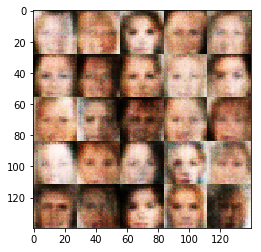

Steps 25/100... Discriminator Loss: 0.6385... Generator Loss: 1.1611
Steps 50/100... Discriminator Loss: 0.8900... Generator Loss: 1.7186
Steps 75/100... Discriminator Loss: 0.7107... Generator Loss: 0.9847
Steps 100/100... Discriminator Loss: 1.3704... Generator Loss: 0.4484


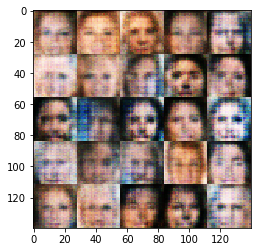

Steps 25/100... Discriminator Loss: 0.6694... Generator Loss: 1.3154
Steps 50/100... Discriminator Loss: 1.2115... Generator Loss: 0.5612
Steps 75/100... Discriminator Loss: 0.8371... Generator Loss: 1.0717
Steps 100/100... Discriminator Loss: 1.0842... Generator Loss: 0.6107


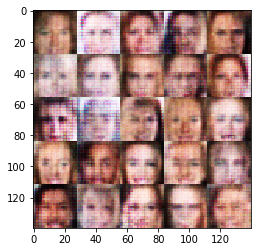

Steps 25/100... Discriminator Loss: 0.7951... Generator Loss: 1.0313
Steps 50/100... Discriminator Loss: 1.6884... Generator Loss: 1.8621
Steps 75/100... Discriminator Loss: 0.8597... Generator Loss: 1.0121
Steps 100/100... Discriminator Loss: 1.1409... Generator Loss: 1.3672


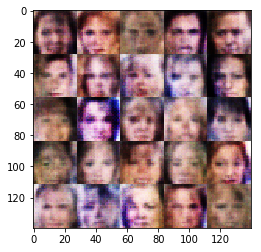

Steps 25/100... Discriminator Loss: 1.0604... Generator Loss: 1.3051
Steps 50/100... Discriminator Loss: 1.1510... Generator Loss: 0.7039
Steps 75/100... Discriminator Loss: 0.8213... Generator Loss: 1.0107
Steps 100/100... Discriminator Loss: 1.0127... Generator Loss: 0.6774


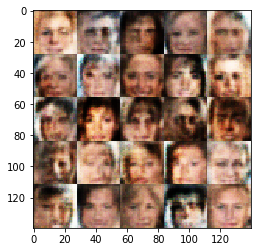

Steps 25/100... Discriminator Loss: 1.5467... Generator Loss: 0.3241
Steps 50/100... Discriminator Loss: 0.7698... Generator Loss: 1.4553
Steps 75/100... Discriminator Loss: 1.0384... Generator Loss: 0.6778
Steps 100/100... Discriminator Loss: 0.9417... Generator Loss: 1.0358


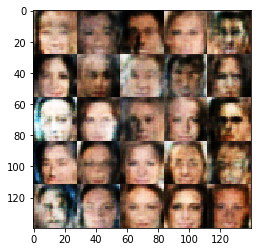

Steps 25/100... Discriminator Loss: 1.0536... Generator Loss: 0.6139
Steps 50/100... Discriminator Loss: 0.8774... Generator Loss: 1.1044
Steps 75/100... Discriminator Loss: 1.3672... Generator Loss: 0.3838
Steps 100/100... Discriminator Loss: 1.2220... Generator Loss: 0.4907


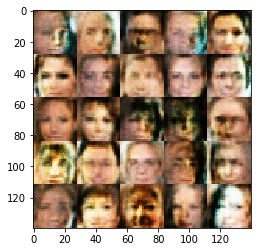

Steps 25/100... Discriminator Loss: 1.3133... Generator Loss: 0.4422
Steps 50/100... Discriminator Loss: 1.0104... Generator Loss: 0.7520
Steps 75/100... Discriminator Loss: 0.8969... Generator Loss: 1.0424
Steps 100/100... Discriminator Loss: 0.6602... Generator Loss: 1.3162


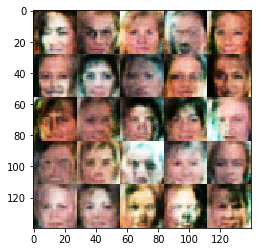

Steps 25/100... Discriminator Loss: 0.6813... Generator Loss: 1.1299
Steps 50/100... Discriminator Loss: 0.7198... Generator Loss: 0.9164
Steps 75/100... Discriminator Loss: 1.5164... Generator Loss: 0.3173
Steps 100/100... Discriminator Loss: 0.7152... Generator Loss: 1.1983


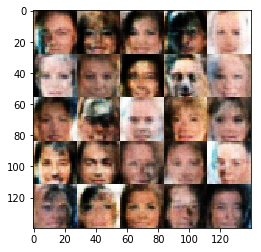

Steps 25/100... Discriminator Loss: 0.7184... Generator Loss: 1.0743
Steps 50/100... Discriminator Loss: 0.9382... Generator Loss: 1.8141
Steps 75/100... Discriminator Loss: 0.5932... Generator Loss: 1.1031
Steps 100/100... Discriminator Loss: 1.9679... Generator Loss: 0.2032


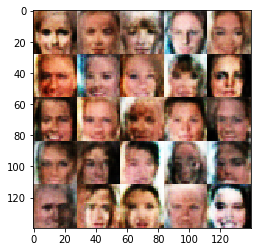

Steps 25/100... Discriminator Loss: 1.0750... Generator Loss: 0.5725
Steps 50/100... Discriminator Loss: 1.0163... Generator Loss: 1.1098
Steps 75/100... Discriminator Loss: 0.7743... Generator Loss: 0.9777
Steps 100/100... Discriminator Loss: 1.5070... Generator Loss: 0.3612


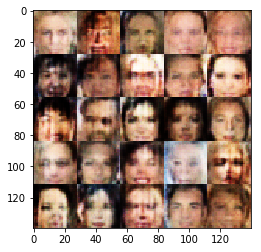

Steps 25/100... Discriminator Loss: 0.7886... Generator Loss: 0.8859
Steps 50/100... Discriminator Loss: 0.4290... Generator Loss: 1.8964
Steps 75/100... Discriminator Loss: 1.2785... Generator Loss: 0.4575
Steps 100/100... Discriminator Loss: 0.8544... Generator Loss: 1.2296


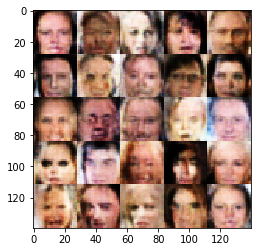

Steps 25/100... Discriminator Loss: 0.6528... Generator Loss: 1.4194
Steps 50/100... Discriminator Loss: 0.4720... Generator Loss: 1.5518
Steps 75/100... Discriminator Loss: 0.7773... Generator Loss: 1.0112
Steps 100/100... Discriminator Loss: 0.7805... Generator Loss: 1.6355


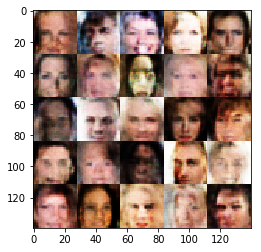

Steps 25/100... Discriminator Loss: 0.7170... Generator Loss: 2.2369
Steps 50/100... Discriminator Loss: 0.3016... Generator Loss: 4.1773
Steps 75/100... Discriminator Loss: 1.3166... Generator Loss: 4.5060
Steps 100/100... Discriminator Loss: 0.3614... Generator Loss: 2.3334


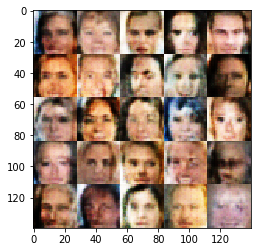

Steps 25/100... Discriminator Loss: 0.4510... Generator Loss: 1.4112
Steps 50/100... Discriminator Loss: 0.1438... Generator Loss: 2.6602
Steps 75/100... Discriminator Loss: 1.0740... Generator Loss: 0.5936
Steps 100/100... Discriminator Loss: 0.2385... Generator Loss: 2.6810


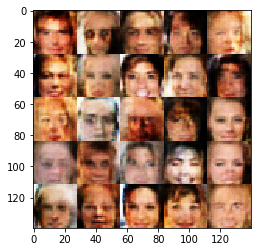

Steps 25/100... Discriminator Loss: 0.3133... Generator Loss: 1.8446
Steps 50/100... Discriminator Loss: 0.9544... Generator Loss: 0.6569
Steps 75/100... Discriminator Loss: 0.3940... Generator Loss: 4.2159
Steps 100/100... Discriminator Loss: 0.0936... Generator Loss: 4.4758


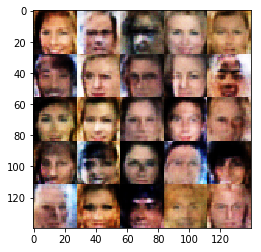

Steps 25/100... Discriminator Loss: 0.4932... Generator Loss: 1.2871
Steps 50/100... Discriminator Loss: 0.2283... Generator Loss: 2.1294
Steps 75/100... Discriminator Loss: 0.9786... Generator Loss: 0.6640
Steps 100/100... Discriminator Loss: 0.3893... Generator Loss: 5.6461


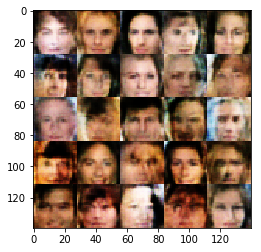

Steps 25/100... Discriminator Loss: 0.1448... Generator Loss: 4.3246
Steps 50/100... Discriminator Loss: 0.1461... Generator Loss: 2.9482
Steps 75/100... Discriminator Loss: 0.2924... Generator Loss: 1.9117
Steps 100/100... Discriminator Loss: 0.0607... Generator Loss: 4.0244


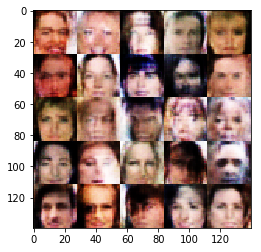

Steps 25/100... Discriminator Loss: 0.1678... Generator Loss: 4.5380
Steps 50/100... Discriminator Loss: 0.3563... Generator Loss: 1.5256
Steps 75/100... Discriminator Loss: 0.0661... Generator Loss: 5.2364
Steps 100/100... Discriminator Loss: 2.0400... Generator Loss: 0.1878


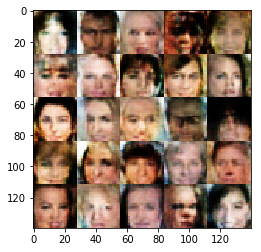

Steps 25/100... Discriminator Loss: 0.3682... Generator Loss: 2.8003
Steps 50/100... Discriminator Loss: 0.1349... Generator Loss: 5.4895
Steps 75/100... Discriminator Loss: 0.9507... Generator Loss: 0.6171
Steps 100/100... Discriminator Loss: 0.0319... Generator Loss: 8.8438


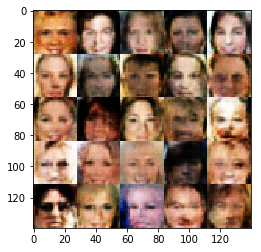

Steps 25/100... Discriminator Loss: 0.1842... Generator Loss: 2.2596
Steps 50/100... Discriminator Loss: 0.0542... Generator Loss: 5.4928
Steps 75/100... Discriminator Loss: 0.0622... Generator Loss: 4.4239
Steps 100/100... Discriminator Loss: 0.2034... Generator Loss: 2.1383


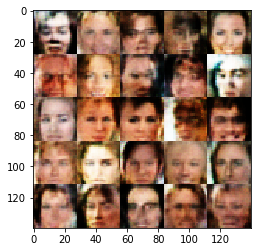

Steps 25/100... Discriminator Loss: 0.3839... Generator Loss: 1.5332
Steps 50/100... Discriminator Loss: 0.2011... Generator Loss: 4.6170
Steps 75/100... Discriminator Loss: 0.0858... Generator Loss: 3.1651
Steps 100/100... Discriminator Loss: 0.0794... Generator Loss: 3.7643


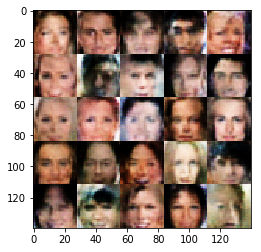

Steps 25/100... Discriminator Loss: 0.2876... Generator Loss: 1.7294
Steps 50/100... Discriminator Loss: 0.1150... Generator Loss: 3.0846
Steps 75/100... Discriminator Loss: 0.4427... Generator Loss: 1.9423
Steps 100/100... Discriminator Loss: 0.1517... Generator Loss: 4.8680


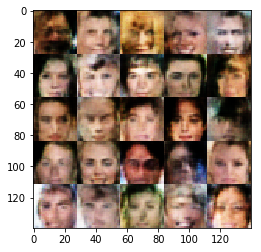

Steps 25/100... Discriminator Loss: 0.1931... Generator Loss: 4.5373
Steps 50/100... Discriminator Loss: 0.0546... Generator Loss: 6.2473
Steps 75/100... Discriminator Loss: 0.0684... Generator Loss: 4.5799
Steps 100/100... Discriminator Loss: 0.4697... Generator Loss: 1.3320


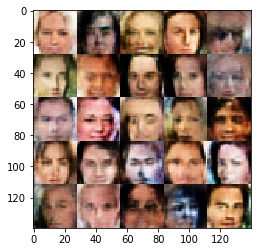

Steps 25/100... Discriminator Loss: 0.0478... Generator Loss: 5.2821
Steps 50/100... Discriminator Loss: 0.3360... Generator Loss: 3.2548
Steps 75/100... Discriminator Loss: 0.0542... Generator Loss: 7.0916
Steps 100/100... Discriminator Loss: 0.1177... Generator Loss: 6.5716


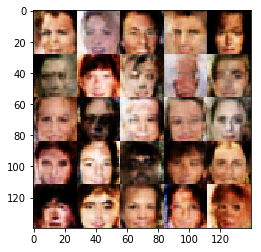

Steps 25/100... Discriminator Loss: 0.0748... Generator Loss: 6.7341
Steps 50/100... Discriminator Loss: 0.0920... Generator Loss: 3.0916
Steps 75/100... Discriminator Loss: 0.0208... Generator Loss: 5.2026
Steps 100/100... Discriminator Loss: 0.0073... Generator Loss: 5.8964


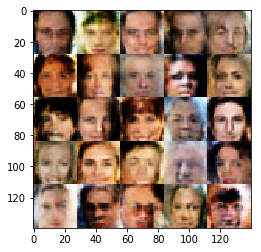

Steps 25/100... Discriminator Loss: 0.0440... Generator Loss: 3.8122
Steps 50/100... Discriminator Loss: 1.0053... Generator Loss: 0.5305
Steps 75/100... Discriminator Loss: 0.1276... Generator Loss: 2.7360
Steps 100/100... Discriminator Loss: 0.9263... Generator Loss: 3.2368


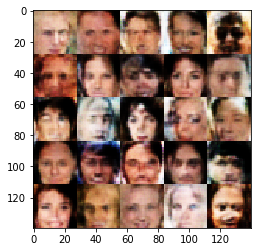

Steps 25/100... Discriminator Loss: 0.1405... Generator Loss: 3.3609
Steps 50/100... Discriminator Loss: 0.0514... Generator Loss: 6.8233
Steps 75/100... Discriminator Loss: 0.5816... Generator Loss: 1.0809
Steps 100/100... Discriminator Loss: 0.0708... Generator Loss: 9.3381


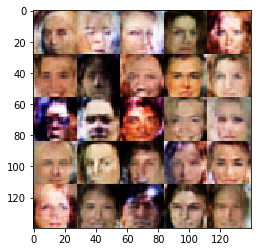

Steps 25/100... Discriminator Loss: 0.6692... Generator Loss: 1.0283
Steps 50/100... Discriminator Loss: 0.0202... Generator Loss: 7.0537
Steps 75/100... Discriminator Loss: 0.1459... Generator Loss: 3.0155
Steps 100/100... Discriminator Loss: 0.0374... Generator Loss: 4.8975


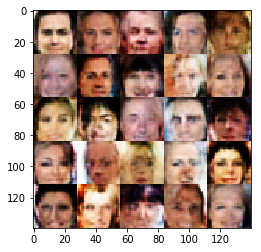

Steps 25/100... Discriminator Loss: 0.1256... Generator Loss: 2.8391
Steps 50/100... Discriminator Loss: 0.0876... Generator Loss: 3.6684
Steps 75/100... Discriminator Loss: 0.0571... Generator Loss: 4.0502
Steps 100/100... Discriminator Loss: 0.0147... Generator Loss: 6.2756


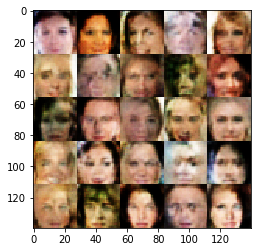

Steps 25/100... Discriminator Loss: 0.2465... Generator Loss: 6.0096
Steps 50/100... Discriminator Loss: 0.1783... Generator Loss: 2.1657
Steps 75/100... Discriminator Loss: 0.2345... Generator Loss: 1.9737
Steps 100/100... Discriminator Loss: 2.2521... Generator Loss: 4.0624


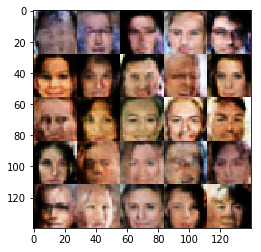

Steps 25/100... Discriminator Loss: 0.7929... Generator Loss: 0.7536
Steps 50/100... Discriminator Loss: 0.0750... Generator Loss: 4.1719
Steps 75/100... Discriminator Loss: 0.0564... Generator Loss: 4.4492
Steps 100/100... Discriminator Loss: 0.0460... Generator Loss: 6.1614


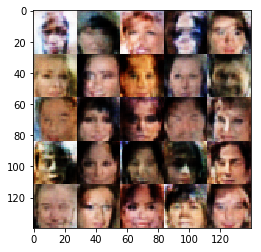

Steps 25/100... Discriminator Loss: 0.1780... Generator Loss: 2.2805
Steps 50/100... Discriminator Loss: 0.1082... Generator Loss: 5.1502
Steps 75/100... Discriminator Loss: 0.0424... Generator Loss: 4.6025
Steps 100/100... Discriminator Loss: 0.1560... Generator Loss: 2.3630


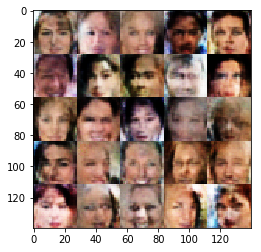

Steps 25/100... Discriminator Loss: 0.6205... Generator Loss: 1.1093
Steps 50/100... Discriminator Loss: 0.2181... Generator Loss: 2.1312
Steps 75/100... Discriminator Loss: 0.0231... Generator Loss: 5.0223
Steps 100/100... Discriminator Loss: 0.0228... Generator Loss: 4.5429


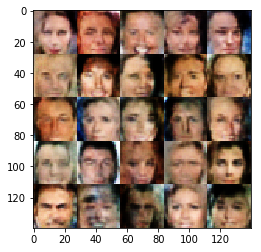

Steps 25/100... Discriminator Loss: 0.0193... Generator Loss: 5.1114
Steps 50/100... Discriminator Loss: 0.0679... Generator Loss: 5.7061
Steps 75/100... Discriminator Loss: 0.0539... Generator Loss: 4.2685
Steps 100/100... Discriminator Loss: 0.0426... Generator Loss: 9.2203


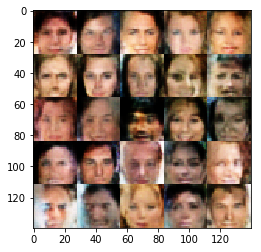

Steps 25/100... Discriminator Loss: 0.0655... Generator Loss: 3.4791
Steps 50/100... Discriminator Loss: 1.9356... Generator Loss: 3.4469
Steps 75/100... Discriminator Loss: 0.2039... Generator Loss: 2.2084
Steps 100/100... Discriminator Loss: 0.0598... Generator Loss: 3.4171


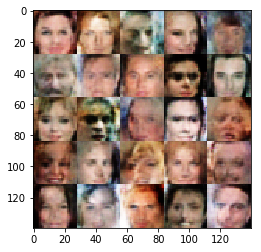

Steps 25/100... Discriminator Loss: 0.0264... Generator Loss: 6.1076
Steps 50/100... Discriminator Loss: 0.0362... Generator Loss: 6.0989
Steps 75/100... Discriminator Loss: 0.0245... Generator Loss: 7.1261
Steps 100/100... Discriminator Loss: 0.0378... Generator Loss: 5.6357


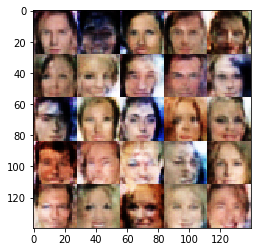

Steps 25/100... Discriminator Loss: 0.4647... Generator Loss: 1.3294
Steps 50/100... Discriminator Loss: 0.1226... Generator Loss: 3.1049
Steps 75/100... Discriminator Loss: 0.0732... Generator Loss: 4.1502
Steps 100/100... Discriminator Loss: 0.0339... Generator Loss: 5.3331


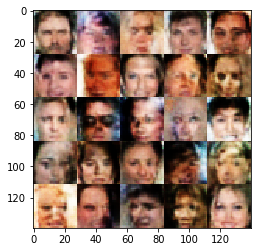

Steps 25/100... Discriminator Loss: 0.0920... Generator Loss: 3.2952
Steps 50/100... Discriminator Loss: 0.0774... Generator Loss: 3.6421
Steps 75/100... Discriminator Loss: 0.0400... Generator Loss: 7.5884
Steps 100/100... Discriminator Loss: 0.0529... Generator Loss: 3.4274


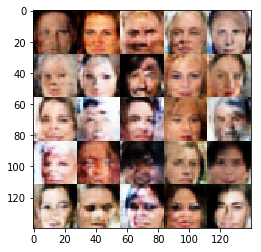

Steps 25/100... Discriminator Loss: 0.0356... Generator Loss: 7.2780
Steps 50/100... Discriminator Loss: 0.0446... Generator Loss: 4.5009
Steps 75/100... Discriminator Loss: 0.0221... Generator Loss: 4.8781
Steps 100/100... Discriminator Loss: 0.1143... Generator Loss: 2.5162


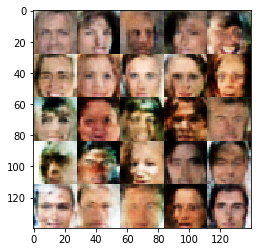

Steps 25/100... Discriminator Loss: 0.0113... Generator Loss: 7.7195
Steps 50/100... Discriminator Loss: 0.0120... Generator Loss: 7.5051
Steps 75/100... Discriminator Loss: 2.4312... Generator Loss: 6.2085
Steps 100/100... Discriminator Loss: 1.8746... Generator Loss: 3.9062


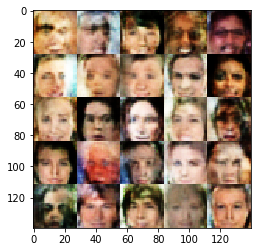

Steps 25/100... Discriminator Loss: 0.3095... Generator Loss: 1.9978
Steps 50/100... Discriminator Loss: 0.0597... Generator Loss: 4.1884
Steps 75/100... Discriminator Loss: 0.5068... Generator Loss: 1.1494
Steps 100/100... Discriminator Loss: 0.5660... Generator Loss: 1.4940


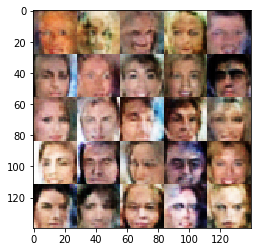

Steps 25/100... Discriminator Loss: 0.2467... Generator Loss: 3.3574
Steps 50/100... Discriminator Loss: 0.0974... Generator Loss: 3.6474
Steps 75/100... Discriminator Loss: 0.0855... Generator Loss: 3.5765
Steps 100/100... Discriminator Loss: 0.0228... Generator Loss: 5.7945


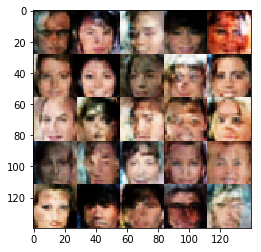

Steps 25/100... Discriminator Loss: 0.0990... Generator Loss: 3.3677
Steps 50/100... Discriminator Loss: 0.0887... Generator Loss: 5.0807
Steps 75/100... Discriminator Loss: 0.0282... Generator Loss: 6.6361
Steps 100/100... Discriminator Loss: 0.0999... Generator Loss: 5.4895


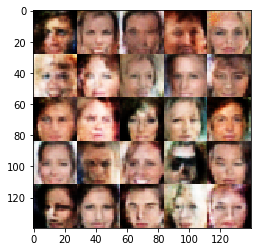

Steps 25/100... Discriminator Loss: 0.0294... Generator Loss: 5.8466
Steps 50/100... Discriminator Loss: 0.0391... Generator Loss: 3.7146
Steps 75/100... Discriminator Loss: 0.0449... Generator Loss: 3.7308
Steps 100/100... Discriminator Loss: 1.8840... Generator Loss: 0.3084


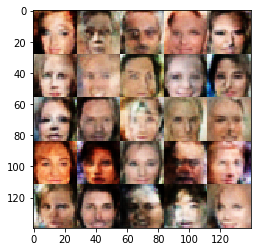

Steps 25/100... Discriminator Loss: 0.0443... Generator Loss: 6.4876
Steps 50/100... Discriminator Loss: 0.0724... Generator Loss: 3.1406
Steps 75/100... Discriminator Loss: 0.0292... Generator Loss: 4.6836
Steps 100/100... Discriminator Loss: 0.1091... Generator Loss: 2.8553


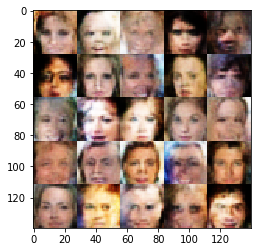

Steps 25/100... Discriminator Loss: 0.0280... Generator Loss: 6.6932
Steps 50/100... Discriminator Loss: 0.1313... Generator Loss: 2.5971
Steps 75/100... Discriminator Loss: 0.4473... Generator Loss: 1.5144
Steps 100/100... Discriminator Loss: 0.2239... Generator Loss: 3.0476


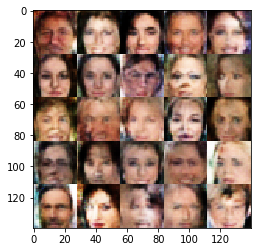

Steps 25/100... Discriminator Loss: 0.2062... Generator Loss: 3.1313
Steps 50/100... Discriminator Loss: 0.0527... Generator Loss: 4.2680
Steps 75/100... Discriminator Loss: 0.1357... Generator Loss: 2.6034
Steps 100/100... Discriminator Loss: 0.3031... Generator Loss: 1.7589


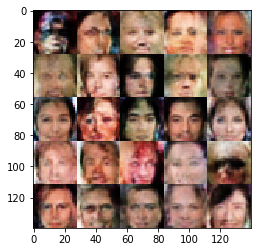

Steps 25/100... Discriminator Loss: 0.1561... Generator Loss: 2.2239
Steps 50/100... Discriminator Loss: 0.0475... Generator Loss: 3.9532
Steps 75/100... Discriminator Loss: 0.2301... Generator Loss: 1.9955
Steps 100/100... Discriminator Loss: 0.0873... Generator Loss: 5.5655


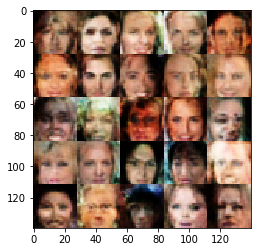

Steps 25/100... Discriminator Loss: 0.0768... Generator Loss: 3.3315
Steps 50/100... Discriminator Loss: 0.0741... Generator Loss: 3.2001
Steps 75/100... Discriminator Loss: 0.0218... Generator Loss: 4.6660
Steps 100/100... Discriminator Loss: 0.0148... Generator Loss: 9.8755


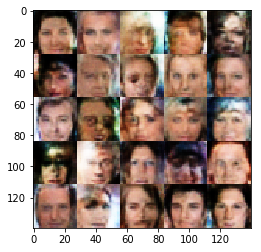

Steps 25/100... Discriminator Loss: 0.0596... Generator Loss: 3.7708
Steps 50/100... Discriminator Loss: 0.0157... Generator Loss: 7.3268
Steps 75/100... Discriminator Loss: 0.0693... Generator Loss: 6.0214
Steps 100/100... Discriminator Loss: 0.1737... Generator Loss: 2.3354


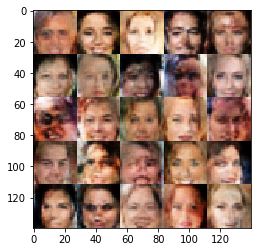

Steps 25/100... Discriminator Loss: 0.9601... Generator Loss: 1.4716
Steps 50/100... Discriminator Loss: 1.2834... Generator Loss: 0.5580
Steps 75/100... Discriminator Loss: 0.4635... Generator Loss: 1.3194
Steps 100/100... Discriminator Loss: 0.5582... Generator Loss: 1.5102


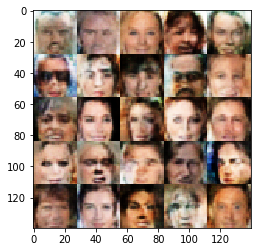

Steps 25/100... Discriminator Loss: 0.2438... Generator Loss: 2.2004
Steps 50/100... Discriminator Loss: 0.2540... Generator Loss: 2.1032
Steps 75/100... Discriminator Loss: 1.4456... Generator Loss: 0.3808
Steps 100/100... Discriminator Loss: 1.2089... Generator Loss: 3.9705


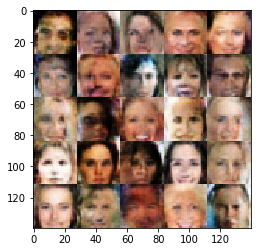

Steps 25/100... Discriminator Loss: 0.8591... Generator Loss: 0.8423
Steps 50/100... Discriminator Loss: 0.2933... Generator Loss: 2.6520
Steps 75/100... Discriminator Loss: 0.2914... Generator Loss: 2.0774
Steps 100/100... Discriminator Loss: 0.0610... Generator Loss: 3.7166


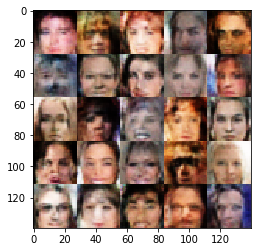

Steps 25/100... Discriminator Loss: 0.0650... Generator Loss: 3.2053
Steps 50/100... Discriminator Loss: 0.0618... Generator Loss: 3.8794
Steps 75/100... Discriminator Loss: 0.0243... Generator Loss: 4.5304
Steps 100/100... Discriminator Loss: 0.0908... Generator Loss: 3.2754


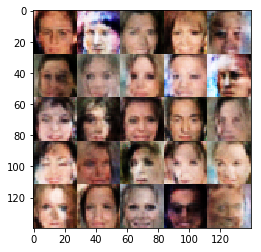

Steps 25/100... Discriminator Loss: 0.0318... Generator Loss: 5.8099
Steps 50/100... Discriminator Loss: 0.1447... Generator Loss: 3.0588
Steps 75/100... Discriminator Loss: 0.1882... Generator Loss: 2.1095
Steps 100/100... Discriminator Loss: 0.0651... Generator Loss: 3.6610


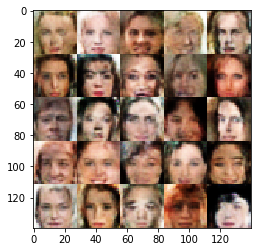

Steps 25/100... Discriminator Loss: 0.0288... Generator Loss: 5.6385
Steps 50/100... Discriminator Loss: 0.0689... Generator Loss: 6.4376
Steps 75/100... Discriminator Loss: 0.3818... Generator Loss: 1.4519
Steps 100/100... Discriminator Loss: 0.1518... Generator Loss: 2.4939


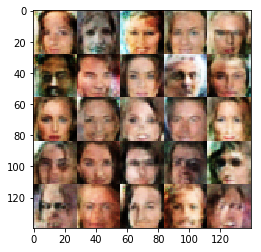

Steps 25/100... Discriminator Loss: 0.1171... Generator Loss: 2.8216
Steps 50/100... Discriminator Loss: 0.0306... Generator Loss: 5.7159
Steps 75/100... Discriminator Loss: 0.0293... Generator Loss: 5.1408
Steps 100/100... Discriminator Loss: 0.0343... Generator Loss: 5.2221


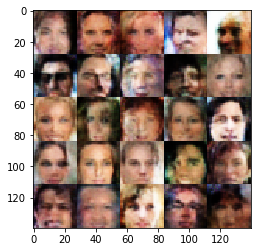

Steps 25/100... Discriminator Loss: 0.0425... Generator Loss: 3.8152
Steps 50/100... Discriminator Loss: 0.0063... Generator Loss: 7.8799
Steps 75/100... Discriminator Loss: 0.8825... Generator Loss: 0.9922
Steps 100/100... Discriminator Loss: 0.3544... Generator Loss: 1.8935


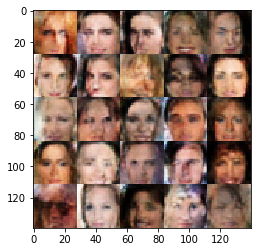

Steps 25/100... Discriminator Loss: 0.2389... Generator Loss: 3.1388
Steps 50/100... Discriminator Loss: 0.7029... Generator Loss: 1.0264
Steps 75/100... Discriminator Loss: 0.0413... Generator Loss: 4.3405
Steps 100/100... Discriminator Loss: 0.1284... Generator Loss: 3.1880


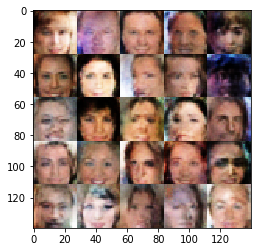

Steps 25/100... Discriminator Loss: 0.1820... Generator Loss: 2.1992
Steps 50/100... Discriminator Loss: 0.0202... Generator Loss: 6.1907
Steps 75/100... Discriminator Loss: 0.0422... Generator Loss: 4.4367
Steps 100/100... Discriminator Loss: 0.1000... Generator Loss: 3.8743


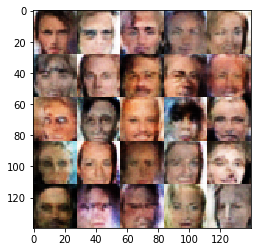

Steps 25/100... Discriminator Loss: 0.1838... Generator Loss: 2.2031


In [21]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.